<a href="https://colab.research.google.com/github/UlianaSalimova/VK_DS_2024/blob/main/EDA_FE_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Импорт необходимых библиотек

In [35]:
pip install tsfel --quiet

In [36]:
pip install hampel --quiet

In [37]:
pip install joblib --quiet

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import datetime as dt
from datetime import datetime
from hampel import hampel
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split, GridSearchCV
from google.colab import files
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import tsfel
import warnings
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
import joblib

#Загрузка данных

In [ ]:
df_train = pd.read_parquet('train.parquet')

#Первичный осмотр данных

Просмотр первых и последних строк данных

In [ ]:
df_train.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.00
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.00
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.00
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.00
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.00


In [ ]:
df_train.tail(4)

,id,dates,values,label
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.00
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.00
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.00
79999,98870,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[0.12, -0.8, 1.62, 0.11, -0.38, -0.86, -0.85, ...",1.00


Получение общей информации о выборке данных

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


<Figure size 1400x800 with 0 Axes>

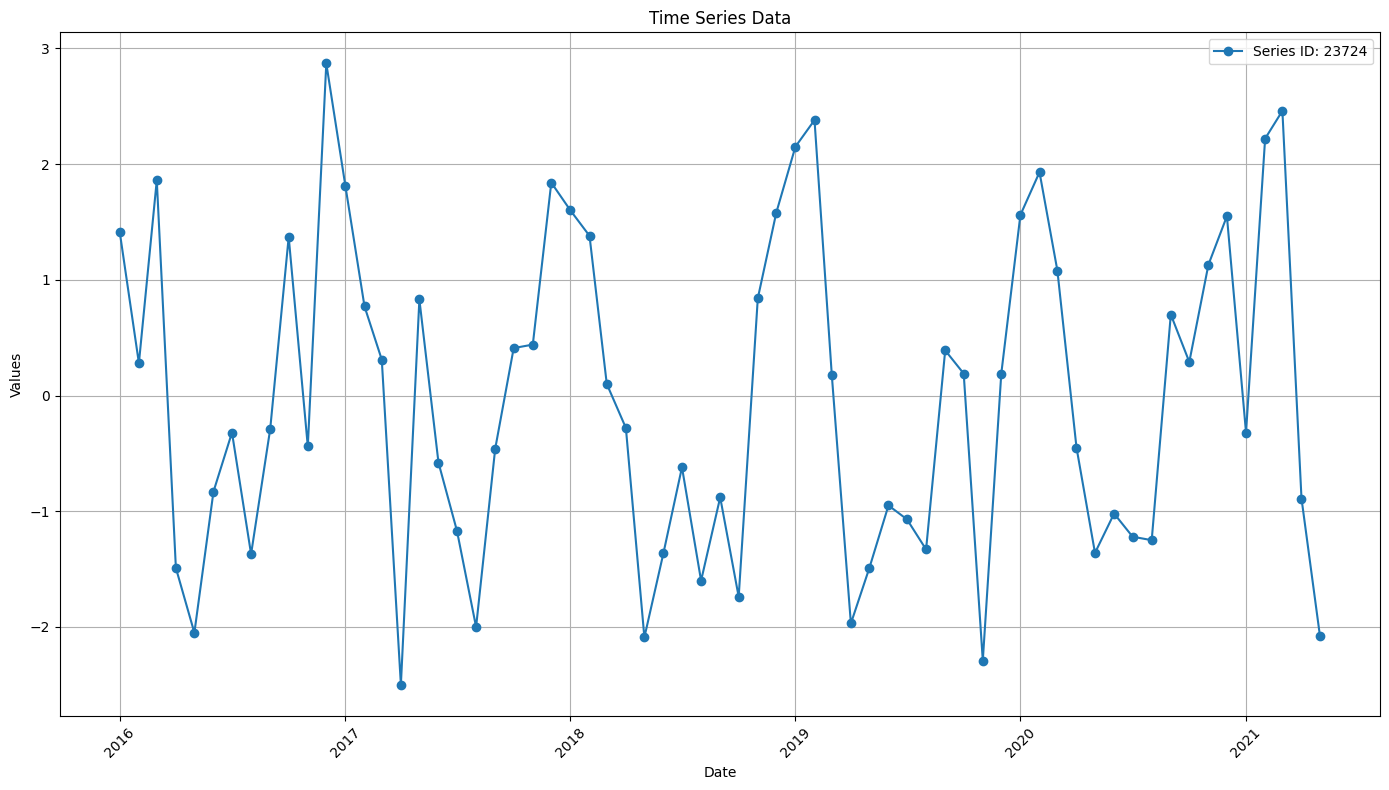

In [ ]:
plt.figure(figsize=(14, 8))

data_subset = df_train[15:16]

dates = np.array(data_subset['dates'].tolist())
values = np.array(data_subset['values'].tolist())
ids = data_subset['id'].values

plt.figure(figsize=(14, 8))

for i in range(len(ids)):
    plt.plot(dates[i], values[i], marker='o', label=f'Series ID: {ids[i]}')

plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Проверка на пропущенные значения

По признакам:

In [ ]:
df_train.isnull().sum()

,0
id,0
dates,0
values,0


По каждому временному ряду:

In [ ]:
missing_values_mask = df_train['values'].apply(lambda x: pd.isna(x).all())
sum_nan = missing_values_mask.sum()
values_miss = df_train[missing_values_mask].copy()

sum_nan

88

In [ ]:
missing_values_mask = df_train['values'].apply(lambda x: pd.isna(x).any())
sum_nan = missing_values_mask.sum()
values_miss = df_train[missing_values_mask].copy()

sum_nan

88

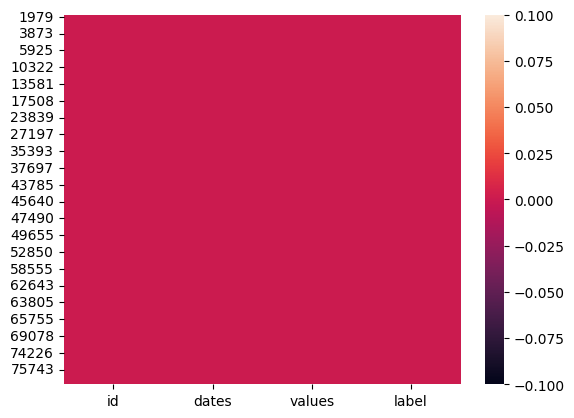

In [ ]:
sns.heatmap(pd.DataFrame(values_miss).isnull(), cbar=True)
plt.show()

Видим, что число временных рядов где пропущены некоторые значения и где нет ни одного значения совпадают, из чего делаем вывод о наличии абсолютно пустых временных рядов и об отсутствии рядов с некоторыми пропущенными значениями. Удалим такие ряды, поскольку их соотношение к общему числу примеров (80000) весьма мало.

In [ ]:
df_train = df_train[df_train['values'].apply(lambda x: not all(pd.isnull(x)))].reset_index(drop=True)
print("Количество рядов после удаления полностью пустых и переиндексации:", len(df_train))

Количество рядов после удаления полностью пустых и переиндексации: 79912


#Проверка на дубликаты

In [ ]:
df = pd.DataFrame({
    'id': df_train['id'],
    'dates': df_train['dates'].apply(lambda x: str(x)),
    'values': df_train['values'].apply(lambda x: str(x)),
    'label': df_train['label']
})

duplicates = df.duplicated().sum()
print("Число строк-дубликатов:", duplicates)

Число строк-дубликатов: 0


#Анализ временных характеристик

**Вычисление и визуализация статистик временных рядов**

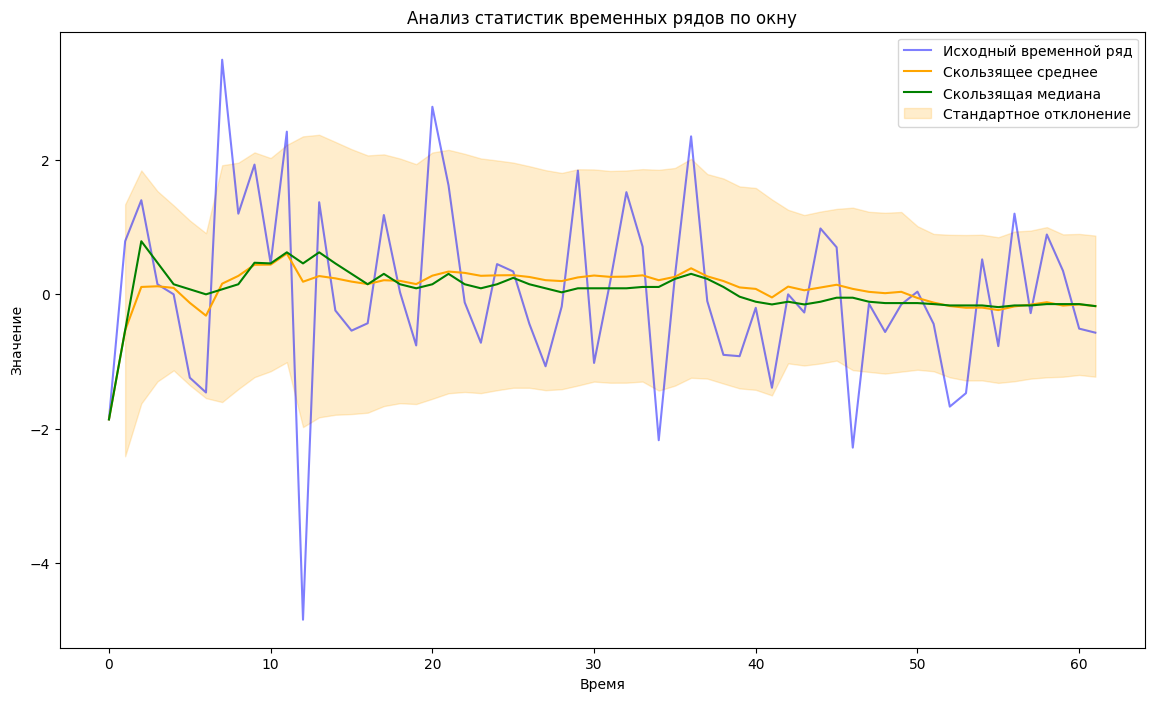

In [ ]:
window_size = 30

values = pd.DataFrame(df_train.loc[0, 'values'])

rolling_mean = values.rolling(window=window_size, min_periods=1).mean()
rolling_median = values.rolling(window=window_size, min_periods=1).median()
rolling_std = values.rolling(window=window_size, min_periods=1).std()

plt.figure(figsize=(14, 8))

plt.plot(values, label='Исходный временной ряд', color='blue', alpha=0.5)

plt.plot(rolling_mean, label='Скользящее среднее', color='orange')

plt.plot(rolling_median, label='Скользящая медиана', color='green')

plt.fill_between(values.index,
                 rolling_mean[0] - rolling_std[0],
                 rolling_mean[0] + rolling_std[0],
                 color='orange', alpha=0.2, label='Стандартное отклонение')

plt.legend()
plt.title('Анализ статистик временных рядов по окну')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.show()

Можно визуально увидеть выбросы, выходящие за границы стандартного отклонения, сравнить их  с результатми полученными при помощи теста Хемпела

**Декомпозиция временного ряда**

Так как в наших данных присутствуют отрацательные значения, то временной ряд не может быть мультипликативным. Рассмотрим разложение аддитивного ряда на составляющие тренда и сезоннсти.

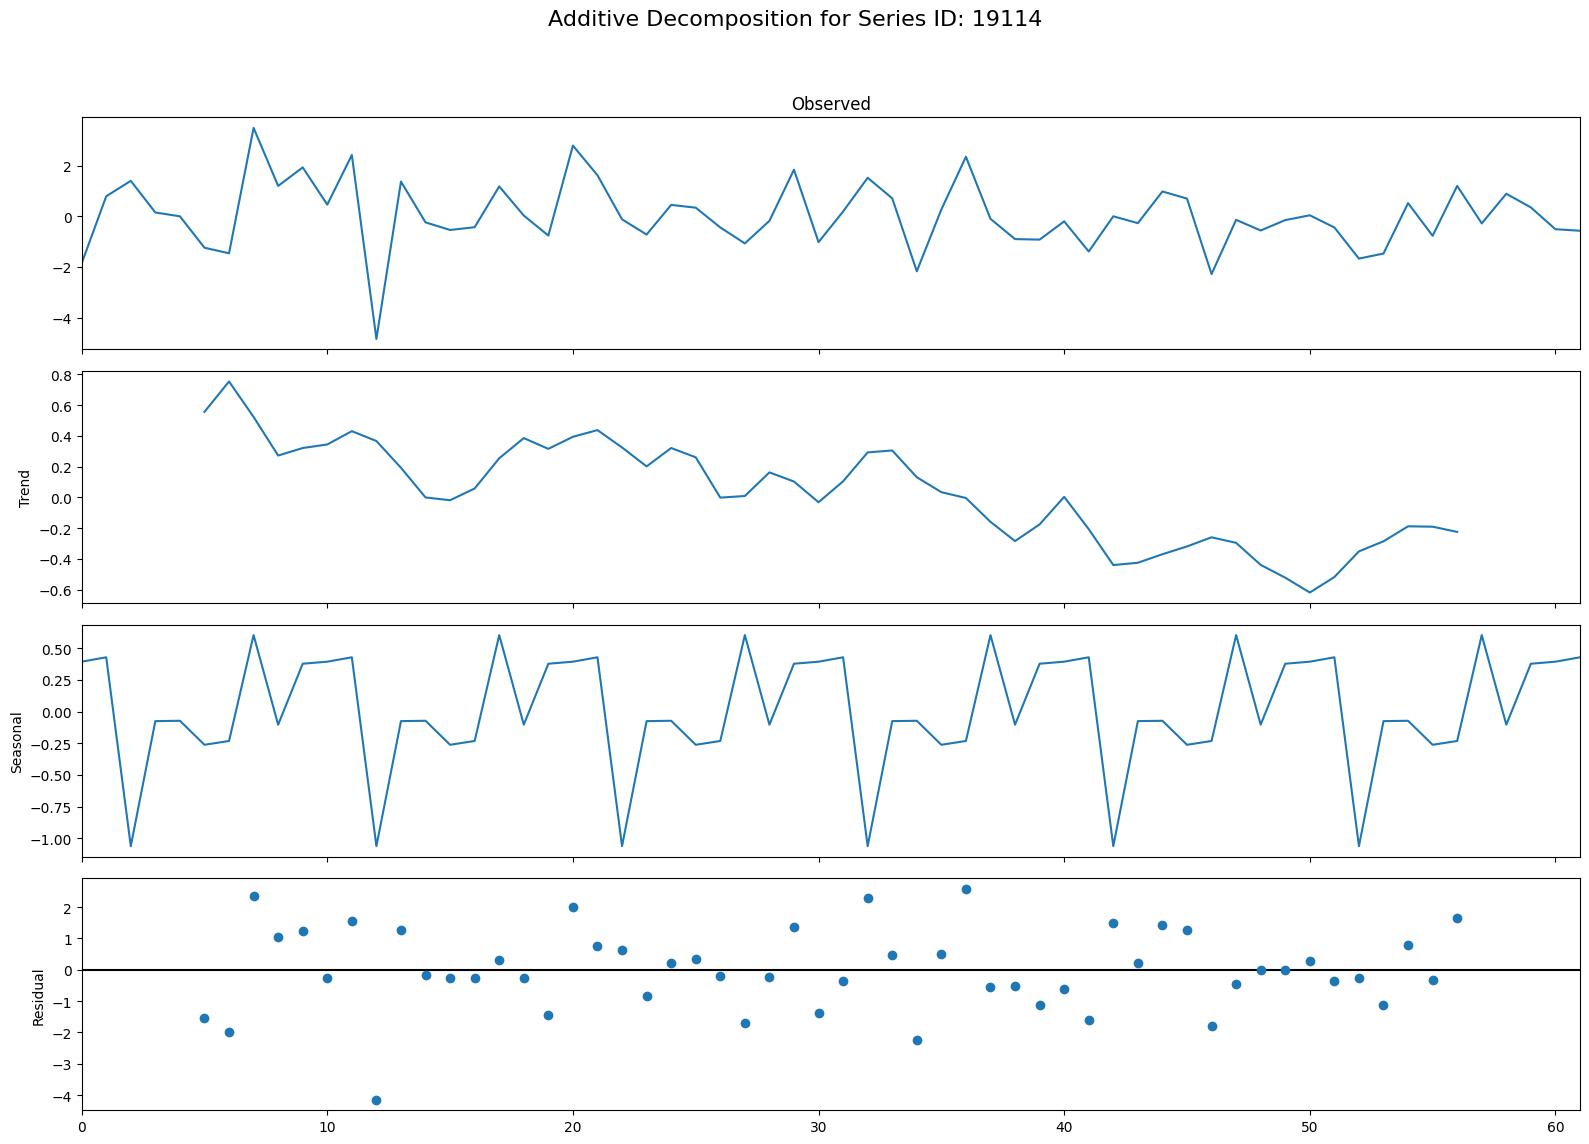

,0
0,None


In [ ]:
def decompose_and_plot(row):
    additive_decomposition = seasonal_decompose(row['values'], model='additive', period=10)
    plt.rcParams.update({'figure.figsize': (16, 12)})
    additive_decomposition.plot().suptitle(f'Additive Decomposition for Series ID: {row["id"]}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


df_train[0:1].apply(decompose_and_plot, axis=1)

В случае обоих классов выраженные тренды и сезонность.

#Анализ статистических выбросов <br>
В результате экспериментов обучения модели было выявлено, что так называемые выбросы хранят в себе значимую информацию, отсутствие/изменение которой значеительно снижает качество модели.

**Выбросы в замерах**

In [ ]:
result = hampel(df_train['values'][15], window_size=7, n_sigma=3.0)
original_data = np.array(df_train['values'][15], dtype=float)
filtered_data = np.array(result.filtered_data, dtype=float)

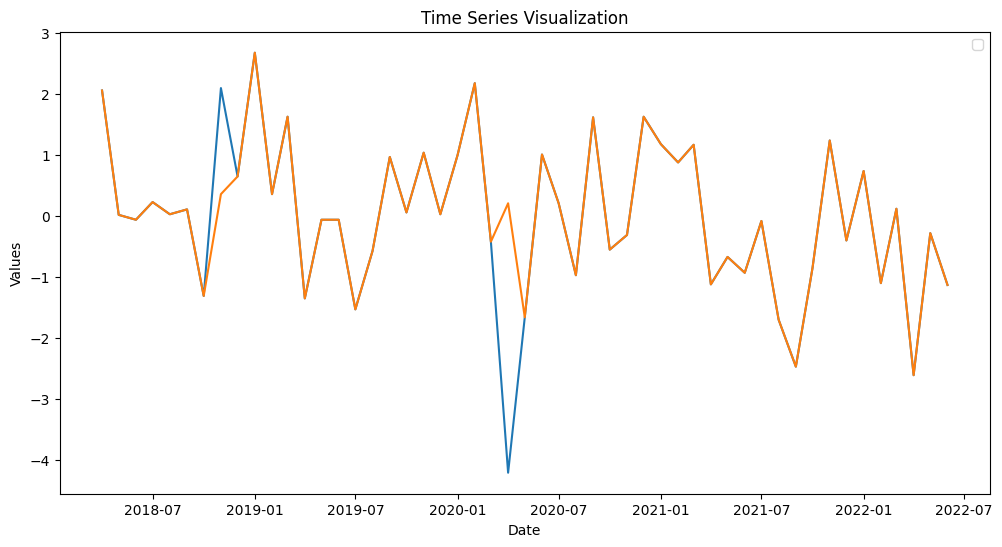

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(df_train['dates'][15]), pd.DataFrame(df_train['values'][15]))
plt.plot(pd.DataFrame(df_train['dates'][15]), pd.DataFrame(result.filtered_data))
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Time Series Visualization")
plt.legend()
plt.show()

**Аномалии в датах**

In [ ]:
start_date = dt.date(2015, 1, 1)
end_date = dt.date(2024, 10, 27)

anomalies = []
for row in df_train.itertuples():
    values = row[2]
    anomaly_dates = [date for date in values if not (start_date <= date <= end_date)]
    anomalies.append(anomaly_dates)

df_train['anomaly_dates'] = anomalies
non_empty_anomalies = df_train[df_train['anomaly_dates'].apply(lambda x: len(x) > 0)]
print(non_empty_anomalies['anomaly_dates'])

Series([], Name: anomaly_dates, dtype: object)


# Анализ рядов с чрезмерно низкой вариацией

In [ ]:
def longest_sequence(lst):
    max_length = 1
    current_length = 1
    longest_element = lst[0]

    for i in range(1, len(lst)):
        if lst[i] == lst[i - 1]:
            current_length += 1
        else:
            if current_length > max_length:
                max_length = current_length
                longest_element = lst[i - 1]
            current_length = 1

    # Проверка в конце списка
    if current_length > max_length:
        max_length = current_length
        longest_element = lst[-1]

    return max_length

In [ ]:
def low_variance(df_train):
  threshold = 10
  low_var = []
  for row in df_train.itertuples():
      values = row[3]
      repeat = longest_sequence(values)
      if repeat > threshold:
        low_var.append(row[0])
  return low_var

In [ ]:
len(low_variance(df_train))

1191

**Пример такого ряда**

0.0


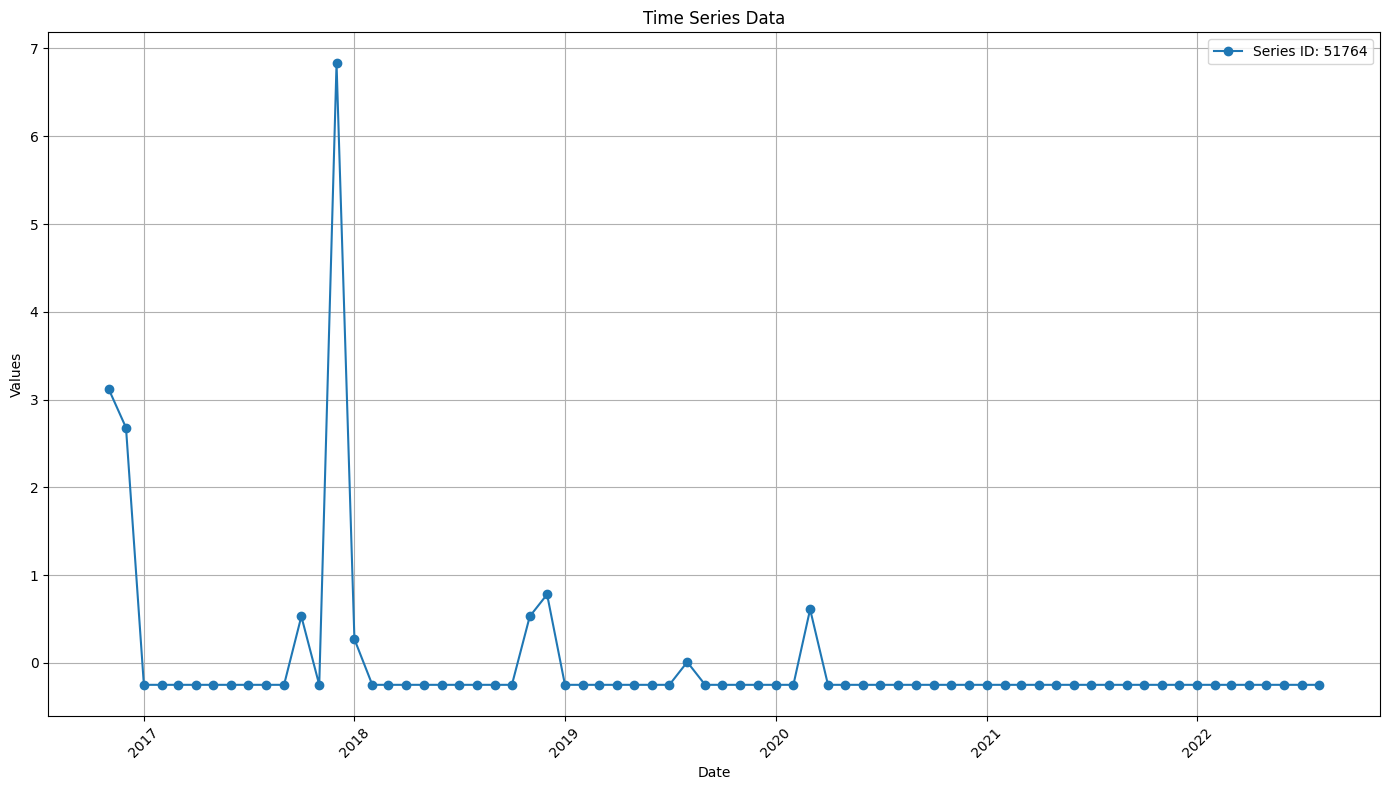

In [ ]:
plt.figure(figsize=(14, 8))

for row in df_train[49968:49969].iterrows():
    plt.plot(row[1]['dates'], row[1]['values'], marker='o', label=f'Series ID: {row[1]["id"]}')
    print(row[1]['label'])

plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
labels_to_remove = df_train.loc[low_var, 'label']
labels_to_remove.value_counts()

,count
label,
0.00,648
1.00,596


Кол-во классов примерно одинаковое, то есть никакой взаимосвязи между таким специфичным распределением временного ряда и классами нет, поэтому удаляем строки

In [ ]:
#Удалим ряды с слишком низкой вариацией данных
final_df = final_df.drop(index=low_var).reset_index(drop=True)
print("Количество рядов после удаления указанных индексов и переиндексации:", len(final_df))

# Статистические тесты

In [ ]:
results = []

for _, row in df_train.iterrows():
    values = pd.Series(row['values'])
    row_id = row['id']  # Предполагается, что id хранится в колонке 'id'

    # 1. Тест на стационарность (ADF)
    adf_result = adfuller(values)
    adf_p_value = adf_result[1]

    # 2. Тест на сезонность (STL-декомпозиция)
    decomposition = seasonal_decompose(values, model='additive', period=10)
    seasonal_strength = decomposition.seasonal.std()

    # 3. Тест на автокорреляцию (ACF)
    acf_values = acf(values, fft=True)
    acf_first_five = acf_values[:5]

    # 4. Тест на нормальность распределения (Шапиро-Уилк)
    shapiro_test = shapiro(values)
    shapiro_p_value = shapiro_test.pvalue

    # Сохранение результатов
    results.append({
        'id': row_id,
        'adf_p_value': adf_p_value,
        'seasonal_strength': seasonal_strength,
        'acf_first_five': acf_first_five,
        'shapiro_p_value': shapiro_p_value
    })

results_df = pd.DataFrame(results)

In [ ]:
def summarize_results(results_df):
    summary = {
        'total_rows': len(results_df),
        'stationary': 0,
        'non_stationary': 0,
        'strong_seasonality': 0,
        'weak_seasonality': 0,
        'autocorrelation': 0,
        'no_autocorrelation': 0,
        'normal_distribution': 0,
        'non_normal_distribution': 0,
    }

    for _, row in results_df.iterrows():
        # Стационарность
        if row['adf_p_value'] < 0.05:
            summary['non_stationary'] += 1
        else:
            summary['stationary'] += 1

        # Сезонность
        if row['seasonal_strength'] > 0.5:
            summary['strong_seasonality'] += 1
        else:
            summary['weak_seasonality'] += 1

        # Автокорреляция
        if any(acf > 0.5 for acf in row['acf_first_five']):
            summary['autocorrelation'] += 1
        else:
            summary['no_autocorrelation'] += 1

        # Нормальность распределения
        if row['shapiro_p_value'] < 0.05:
            summary['non_normal_distribution'] += 1
        else:
            summary['normal_distribution'] += 1

    return summary

# Вызов функции и вывод сводной статистики
summary_results = summarize_results(results_df)

# Печать результатов
for key, value in summary_results.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

Total Rows: 79912
Stationary: 23653
Non Stationary: 56259
Strong Seasonality: 19981
Weak Seasonality: 59931
Autocorrelation: 79912
No Autocorrelation: 0
Normal Distribution: 53397
Non Normal Distribution: 26515


Большинство временных рядов нестационарны (p-value > 0.05), но tsfel автоматически извлекает признаки, которые компенсируют это свойство, такие как статистические и частотные компоненты

Ряды показывают признаки сезонности, которая будет учтена в частотных признаках, извлеченных с помощью tsfel

Присутствие автокорреляции подтверждено тестом Ljung-Box и автокорреляционной функцией. Это свойство также будет учтено через автокорреляционные признаки tsfel

Большинство рядов  соответствует нормальному распределению, а для оставшихся tsfel извлекает статистические и временные признаки, устойчивые к распределению данных

#Генерация признаков

In [ ]:
warnings.filterwarnings("ignore")
def features(df_train):
  features_list = []
  column_names = []
  for row in df_train.itertuples():

      values = pd.Series(row[3])

      cfg = tsfel.get_features_by_domain()
      features = (tsfel.time_series_features_extractor(cfg, values, verbose = -1)).iloc[:,:140]

      features_list.append(np.array(features)[0])

      if not column_names:
          column_names = features.columns.tolist()

  features_df = pd.DataFrame(features_list, columns=column_names)

  corr_features, features_df = tsfel.correlated_features(features_df, drop_correlated=True)

  column_names = features_df.columns.tolist()

  selector = VarianceThreshold()
  features_df = selector.fit_transform(features_df)

  scaler = preprocessing.StandardScaler()
  features_df = scaler.fit_transform(features_df)

  features_df = pd.DataFrame(features_df, columns=column_names)

  final_df = pd.concat([df_train.reset_index(drop=True), features_df], axis=1)

  return(final_df)

# Загрузка и обработка тренировочных и тестовых данных

In [ ]:
def data_prep_train(df):

  #Удаляем пустые значения
  df = df[df['values'].apply(lambda x: not all(pd.isnull(x)))].reset_index(drop=True)

  #Удалим ряды с слишком низкой вариацией данных
  low_var = low_variance(df)
  df = df.drop(index=low_var).reset_index(drop=True)

  #Генерируем признаки
  df = features(df)

  #Удаляем ненужные столбцы
  df.drop(['id','values','dates'], axis=1, inplace = True)

  return df

In [ ]:
def data_prep_test(df, reference_columns):

  df['values'] = df['values'].apply(lambda x: x if not all(pd.isnull(x)) else [0]*len(x))

  #Генерируем признаки
  df = features(df)

  #Удаляем ненужные столбцы
  df.drop(['id','values','dates'], axis=1, inplace = True)

  #Берем совпадающие признаки
  df = df.reindex(columns=reference_columns, fill_value=0)

  return df

In [ ]:
df_train = pd.read_parquet('train.parquet')
df_test = pd.read_parquet('test.parquet')

In [ ]:
df_test.head()

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."


In [ ]:
df_train = data_prep_train(df_train)
reference_columns = df_train.columns.tolist()

In [ ]:
df_train.to_csv('final_features_train.csv', index=False, encoding='utf-8')
files.download('final_features_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_test_prep = data_prep_test(df_test, reference_columns)

In [ ]:
df_test_prep.to_csv('final_features_test.csv', index=False, encoding='utf-8')
files.download('final_features_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_test_prep.shape

(20000, 121)

#Классификация <br>

**Балансировка классов для обучающей выборки**

In [22]:
df_train['label'].value_counts()

,count
label,
0.0,57166
1.0,21555


В результате экспериментов с балансировкой классов было выяснено, что в данном случае прогноз будет более корректен при несбалансированности выборки, иначе возникает переобучение

**Настройка и валидиация модели**

In [23]:
target_column = df_train.label
df_train.drop(['label'], axis=1, inplace=True)
X = df_train
y = target_column.loc[df_train.index]

In [39]:
X.shape

(78721, 120)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78721 entries, 0 to 78720
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                78721 non-null  int64  
 1   is_normal         78721 non-null  bool   
 2   mean              78721 non-null  float64
 3   std               78721 non-null  float64
 4   min               78721 non-null  float64
 5   max               78721 non-null  float64
 6   median            78721 non-null  float64
 7   q25               78721 non-null  float64
 8   q75               78721 non-null  float64
 9   range             78721 non-null  float64
 10  skew              78721 non-null  float64
 11  kurtosis          78721 non-null  float64
 12  variance          78721 non-null  float64
 13  unique_count      78721 non-null  int64  
 14  max_repeats       78721 non-null  int64  
 15  longest_sequence  78721 non-null  int64  
 16  seasonal_mean     78721 non-null  float6

In [30]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=123)

In [11]:
clf = lgb.LGBMClassifier(verbose=-1)

In [129]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0.05, 0.1, 0.2],
    'reg_lambda': [0.05, 0.1, 0.2]
}

# Поиск гиперпараметров с использованием кросс-валидации на валидационной выборке
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Лучшие гиперпараметры
print("Лучшие гиперпараметры:", grid_search.best_params_)

# Обучение модели с лучшими гиперпараметрами
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

# Прогнозирование на валидационной выборке
y_val_pred = best_clf.predict(X_val)

# Оценка точности на валидационной выборке
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation accuracy: {val_accuracy:.4f}')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Лучшие гиперпараметры: {'learning_rate': 0.2, 'reg_alpha': 0.2, 'reg_lambda': 0.05}
Validation accuracy: 0.8967


In [32]:
from sklearn.metrics import accuracy_score

y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy with best hyperparameters: {accuracy:.4f}')

Accuracy with best hyperparameters: 0.8694


In [33]:
y_test_proba = best_clf.predict_proba(np.array(X_test))
roc_auc_score(y_test, y_test_proba[:, 1])

0.9172443536469156

In [28]:
best_clf.fit(np.array(df_train), y)

LGBMClassifier(learning_rate=0.2, reg_alpha=0.2, reg_lambda=0.05, verbose=-1)

In [29]:
# Сохранение модели в файл
model_filename = 'my_model.pkl'
joblib.dump(best_clf, model_filename)
print(f"Модель сохранена в файл: {model_filename}")

Модель сохранена в файл: my_model.pkl
